# Portfolio Intro Example

In [4]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

### Example 4: Portfolio management


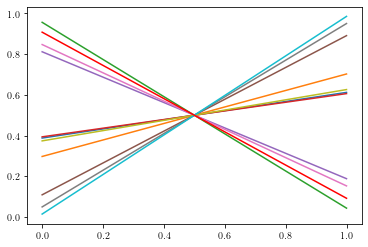

In [2]:
def data_scaled(N, m, scale, seed):
    np.random.seed(seed)
    R = np.vstack([np.random.normal(
    0.1 + 3*i*0.035*scale, np.sqrt((0.02**2+(3*i*0.08)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

def data_modes(N, m, scales, seed):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = data_scaled(weights, m, scales[i], seed)
    return d[0:N, :]

def loss(t,x,p,alpha, data,mu=1000,l=10000,quantile = 0.95, target = -0.1, eta = 0.2):
    sums = 0
    totsum = 0
    Nsample = data.shape[0]
    sums += torch.sum(torch.maximum(-data@x - t - alpha, torch.tensor(0.,requires_grad = True)))
    totsum += torch.sum(torch.where(torch.maximum(-data@x - t - alpha, torch.tensor(0.,requires_grad = True))>= 0.001,torch.tensor(1.), torch.tensor(0.)))
    sums = (sums/((1-quantile)*Nsample)) + alpha
    return t + eta*torch.norm(x-p,1) + torch.tensor(l)*(sums - torch.tensor(target)) + torch.tensor(mu/2)*(sums - torch.tensor(target))**2, t + eta*torch.norm(x-p,1), totsum/Nsample, sums.detach().numpy()

n = 2
eta = 0.2
N = 300
seed = 15
np.random.seed(seed)
data = data_modes(600,n,[1],seed = seed)

# use log-normal instead of normal dist 
data = np.exp(data)
dist = (np.array([250,100,60,50,40,30,30,20,20,15,10,10,10,5,5,1])/10)[:n]

# Use this to control the distribution of x_prev
dist = np.array([1,1])
scenarios = {}
num_scenarios = 10
for scene in range(num_scenarios):
    np.random.seed(scene)
    scenarios[scene] = {}
    scenarios[scene][0] = np.reshape(np.random.dirichlet(dist,1),(n,))

for i in range(num_scenarios):
  plt.plot(scenarios[i][0])

x = cp.Variable(n)
t = cp.Variable()
p = cp.Parameter(n)
p.value = scenarios[0][0]
# p1.value = scenarios[0][1]
objective = cp.Minimize(t)

constraints = [-data@x <= t,cp.sum(x)==1, x >= 0]
prob = lropt.RobustProblem(objective, constraints)
prob.solve()
plt.plot(x.value, color = "red")

In [3]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x = cp.Variable(n)
t = cp.Variable()
p = cp.Parameter(n)
p.value = scenarios[0][0]
# p1.value = scenarios[0][1]
objective = cp.Minimize(t + eta*cp.norm(x - p,1))

constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

prob = lropt.RobustProblem(objective, constraints)
target = -0.05
test_p = 0.5
s = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)
# Train A and b
result1 = prob.train(lr = 0.0001, step=1500, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_mu = 5, init_lam = 0, target_cvar = target, init_alpha = 0., mu_multiplier = 1.01, test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, max_inner_iter = 1)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result3 = prob.train(eps = True, lr = 0.0001, step=1500, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 5, init_lam = 0,  target_cvar = target, init_alpha =0.,mu_multiplier = 1.01,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.001, 5, 50), init_A = result3.A, init_b = result3.b, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.001, 5, 50), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

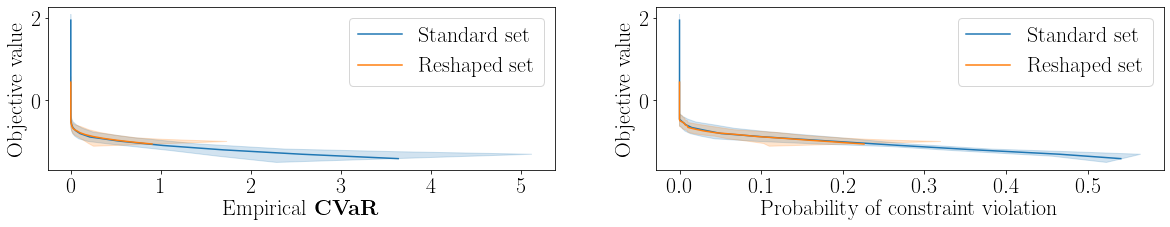

In [5]:
plot_tradeoff(dfgrid,dfgrid2,"intro_port")

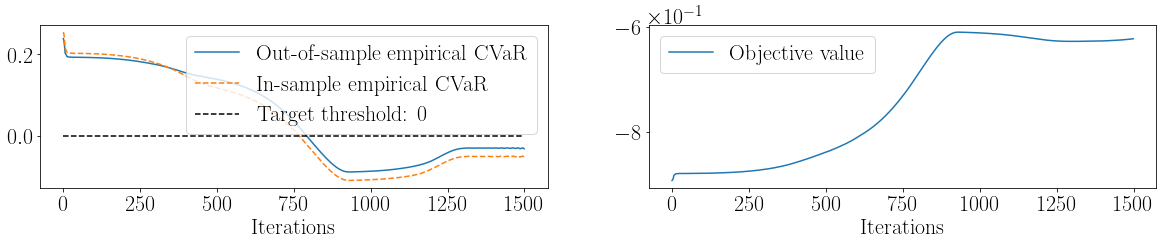

In [7]:
plot_iters(df1,"intro_port")

In [7]:
eps_list = np.linspace(0.001, 5, 50)
inds = [20,13,10,7]

x_opt_base = {}
x_opt_learned = {}
t_learned = {}
t_base = {}
for ind in range(4):
    x_opt_base[ind] = {}
    x_opt_learned[ind] = {}
    t_learned[ind] = {}
    t_base[ind] = {}
    for scene in range(num_scenarios):
        n = 2
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds[ind]])*result3.A, b = (1/eps_list[inds[ind]])*result3.b))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        t = cp.Variable()
        p = scenarios[scene][0]
        # y = cp.Variable()

        objective = cp.Minimize(t + eta*cp.norm(x_r - p,1))

        constraints = [-x_r@u <= t, cp.sum(x_r)==1, x_r >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        # result3.reform_problem.solve()
        x_opt_base[ind][scene] = x_r.value

        t_base[ind][scene] = t.value

        n = 2
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds[ind]])*A_fin, b = (1/eps_list[inds[ind]])*b_fin))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        t = cp.Variable()
        p = scenarios[scene][0]
        # y = cp.Variable()

        objective = cp.Minimize(t + eta*cp.norm(x_r - p,1))

        constraints = [-x_r@u <= t, cp.sum(x_r)==1, x_r >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        x_opt_learned[ind][scene] = x_r.value

        t_learned[ind][scene] = t.value
        x_opt_learned,x_opt_base,t_learned, t_base

(array([[3.49392269, 0.14065384],
        [0.01112962, 1.46525649]]),
 array([-3.54736145, -1.64126155]),
 array([[ 3.21374225, -0.13256929],
        [-0.13256929,  1.31384682]]),
 array([-3.8668744 , -1.81524942]))

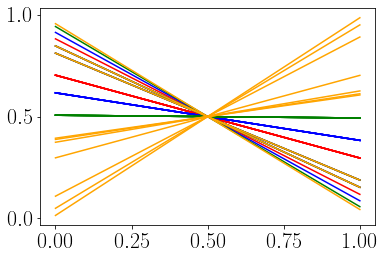

In [8]:
colors_plot = ["red","blue","green","orange"]
for ind in range(4):
    for scene in range(num_scenarios):
        plt.plot(x_opt_learned[ind][scene], color = colors_plot[ind])

Text(0.5, 0.98, 'Standard set')

<Figure size 360x360 with 0 Axes>

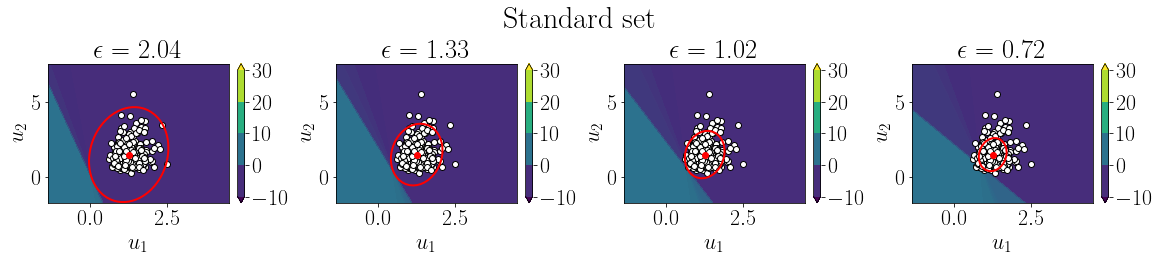

In [9]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"
K =1
plt.figure(figsize=(5, 5))
num_p = 50
offset = 2
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(4):
    g_level_learned[ind] = {}
    g_level_base[ind] = {}
    for scene in range(num_scenarios):
        g_level_learned[ind][scene] = np.zeros((num_p,num_p))
        g_level_base[ind][scene] = np.zeros((num_p,num_p))
# init_set = np.zeros((num_p,num_p))
    # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/eps_list[inds[ind]])*b_fin)

            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*result3.A[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  + (1/eps_list[inds[ind]])*result3.b)
            
            for scene in range(num_scenarios):
                g_level_learned[ind][scene][i,j] = - x_opt_learned[ind][scene]@u_vec - t_learned[ind][scene]
                g_level_base[ind][scene][i,j] =  - x_opt_base[ind][scene]@u_vec - t_base[ind][scene]


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
ax_lst = [ax1, ax2, ax3, ax4]

cur_ind = 0
contours = []
for axis in ax_lst:
    axis.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[cur_ind]],2)))
    axis.set_xlabel(r"$u_1$")
    axis.set_ylabel(r"$u_2$")
    for k_ind in range(K):
        axis.contour(x,y,init_set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])

    a1 = axis.contourf(x,y,g_level_base[cur_ind][0],np.arange(-10, 40, 10),extend='both',alpha = 1)
    contours.append(a1)
    for scene in range(1,num_scenarios):
        a1 = axis.contourf(x,y,g_level_base[cur_ind][scene],np.arange(-10, 40, 10),extend='both',alpha = 0.3)
        contours.append(a1)
    axis.scatter(train[:,0],train[:,1], color = "white" ,edgecolors= "black")
    axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["red"])
    cur_ind +=1
    fig.colorbar(contours[0], ax = axis)

fig.suptitle("Standard set", fontsize = 30)

# plt.savefig("Port_standard.pdf", bbox_inches='tight')


In [ ]:
def plot_contours(set, g_level,):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
    ax_lst = [ax1, ax2, ax3, ax4]

    cur_ind = 0
    contours = []
    for axis in ax_lst:
        axis.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[cur_ind]],2)))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        for k_ind in range(K):
            axis.contour(x,y,init_set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])

        a1 = axis.contourf(x,y,g_level_base[cur_ind][0],np.arange(-10, 40, 10),extend='both',alpha = 1)
        contours.append(a1)
        for scene in range(1,num_scenarios):
            a1 = axis.contourf(x,y,g_level_base[cur_ind][scene],np.arange(-10, 40, 10),extend='both',alpha = 0.3)
            contours.append(a1)
        axis.scatter(train[:,0],train[:,1], color = "white" ,edgecolors= "black")
        axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["red"])
        cur_ind +=1
        fig.colorbar(contours[0], ax = axis)

    fig.suptitle("Standard set", fontsize = 30)

    # plt.savefig("Port_standard.pdf", bbox_inches='tight')


Text(0.5, 0.98, 'Reshaped set')

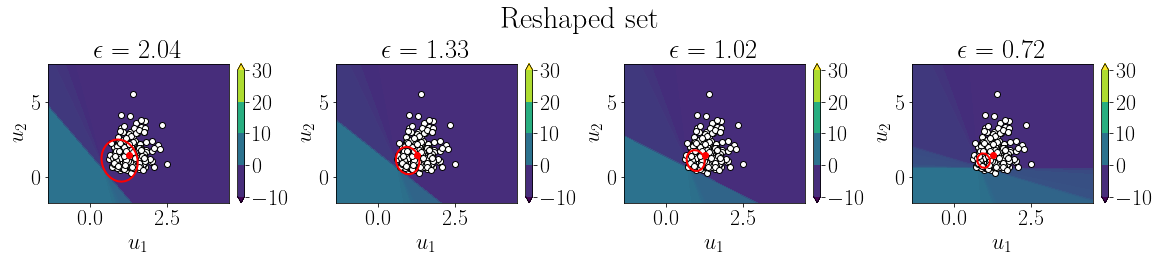

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
ax_lst = [ax1, ax2, ax3, ax4]
cur_ind = 0
contours = []
for axis in ax_lst:
    axis.set_title(r"$\epsilon$ = {}".format(round(eps_list[inds[cur_ind]],2)))
    axis.set_xlabel(r"$u_1$")
    axis.set_ylabel(r"$u_2$")
    for k_ind in range(K):
        axis.contour(x,y,fin_set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
    a1 = axis.contourf(x,y,g_level_learned[cur_ind][0],np.arange(-10, 40, 10),extend='both',alpha = 1)
    contours.append(a1)
    for scene in range(1,num_scenarios):
        a1 = axis.contourf(x,y,g_level_learned[cur_ind][scene],np.arange(-10, 40, 10),extend='both',alpha = 0.3)
        contours.append(a1)
    axis.scatter(train[:,0],train[:,1], color = "white" ,edgecolors= "black")
    axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["red"])
    fig.colorbar(contours[0], ax = axis)
    cur_ind +=1
fig.suptitle("Reshaped set", fontsize = 30)

# plt.savefig("Port_reshape.pdf", bbox_inches='tight')
